In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd
import re
import matplotlib
font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)

In [30]:
def degree(g, nodes=None, as_list=True):
    deg = dict(g.degree())
    if nodes: deg = dict(g.degree(nodes))
    
    if as_list: return list(deg.values())
    return deg

def degree_plot(g, nodes=None, title=''):
    deg = degree(g, nodes=nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.figure(figsize=[15,10])
    plt.plot(means, freqs, ".", markersize=20)
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    plt.show()
    
    # LOG LOG PLOT
    plt.figure(figsize=[15,10])
    plt.loglog(means, freqs, ".", markersize=20)
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    plt.show()

In [2]:
USER = 'user'
ELITE_USER = 'elite_user'
BIZ = 'biz'

In [3]:
biz = pd.read_csv('toronto/toronto_biz.csv')
user = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.read_csv('toronto/toronto_reviews.csv')
elite_user = user[~user.elite.str.contains('None')]

In [4]:
print('#Reviews:', len(reviews))
print('#Users:', len(set(reviews.user_id)))
print('#Elite users:', len(elite_user))
print('#Businesses:', len(set(reviews.business_id)))

#Reviews: 379875
#Users: 84624
#Elite users: 7499
#Businesses: 9678


In [45]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,f5O7v_X_jCg2itqacRfxhg,0,2017-10-12,0,kS4hrhEScwB9V5JATYjvVQ,5,Sansotei serves some top notch ramen. They tak...,0,hxqo4NyJFfeOmuoVi--s1A
1,7xA6iSP0Ndn08tpBFQtUKA,0,2017-05-22,0,YDJDfKnx6VpMMo4EBxycGg,1,Non-existened service! The waiter did not eve...,0,FCtoTo9zSH1cSAkascfEHw
2,SmizR7MLt-558FJJQRBBoQ,1,2011-06-01,1,2Hk7DNwu3rb2jKHaFfPyCA,4,It might be a bit unfair to review Globe so ea...,1,YHWsLBS8jzZiPjKHMFOaAA
3,iKMLsX1Je7P3wAOEc9scDg,0,2011-11-07,0,D2TcNaPqXxDGQ6T0n-vHXw,4,I have been itching to get to Origin for month...,4,YHWsLBS8jzZiPjKHMFOaAA
4,gl1zQmiA8MUHmLL2wsCdVA,1,2011-01-10,0,ZOBEhxOeMnncqIJFkGumRA,3,Away from the hubbub of the Annex and Little K...,2,YHWsLBS8jzZiPjKHMFOaAA


In [5]:
user.head()

,average_stars,elite,friends,name,review_count,useful,user_id,yelping_since
0,2.00,None,None,Susan,1,0,lzlZwIpuSWXEnNS91wxjHw,2015-09-28
1,1.00,None,None,Ying,1,0,bwPVGW1Mx0qmS_qNQ7xmYg,2012-02-09
2,3.50,None,None,Vai,4,0,JcKUiHAQ9cWGSO_qFbzlKw,2009-12-28
3,1.75,None,None,Walter,4,1,mNzy0-YVTJTP2jqHR7zWwQ,2014-05-31
4,2.00,None,None,K,3,0,AAxJbjcq94NaqUJGFE362g,2013-07-08


## Social Network (Friends)
### Make friend List

In [6]:
elite_ids = set(elite_user.user_id)

In [7]:
users_with_friends = user[user.friends != 'None']

In [8]:
friend_list = dict()
for row in users_with_friends.itertuples():
    friend_list[row.user_id] = re.findall(r'\w+', row.friends)

In [9]:
users_with_friends.iloc[0].user_id

'_a7BES74d_thQfpNBuk8Gw'

### Creating the social network

In [11]:
# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

In [64]:
review_network = nx.Graph()
for r in reviews.itertuples():
    a = Node(r.user_id, ELITE_USER if r.user_id in elite_ids else USER)
    b = Node(r.business_id, BIZ)
    review_network.add_edge(a, b, weight=r.stars)

#### Degree distributions

In [71]:
review_biz_nodes = [n for n in list(review_network.nodes()) if n.Type == BIZ]
review_user_nodes = [n for n in list(review_network.nodes()) if n.Type == USER]
review_elite_nodes = [n for n in list(review_network.nodes()) if n.Type == ELITE_USER]

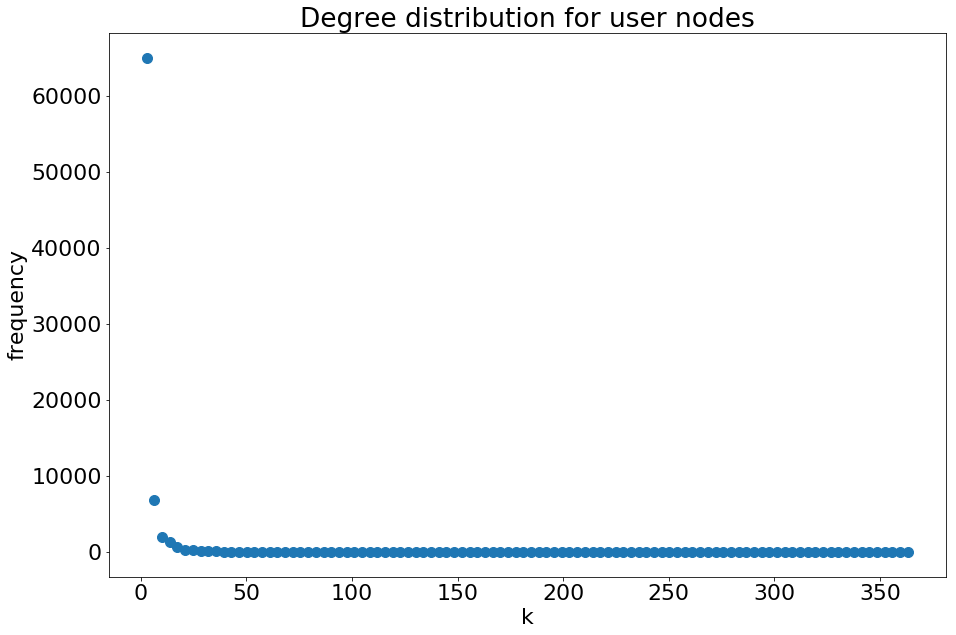

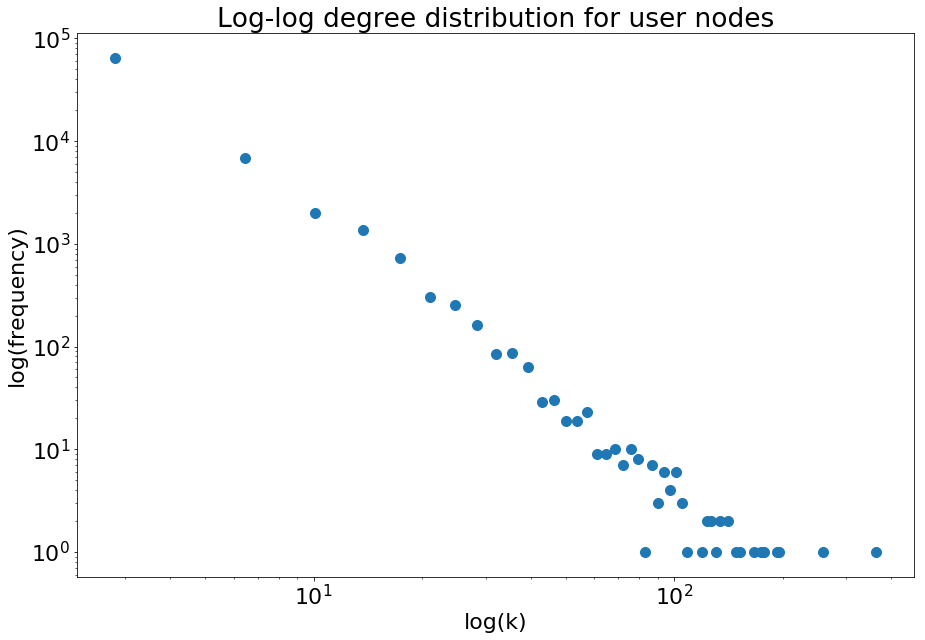

In [69]:
degree_plot(review_network, review_user_nodes, "user nodes")

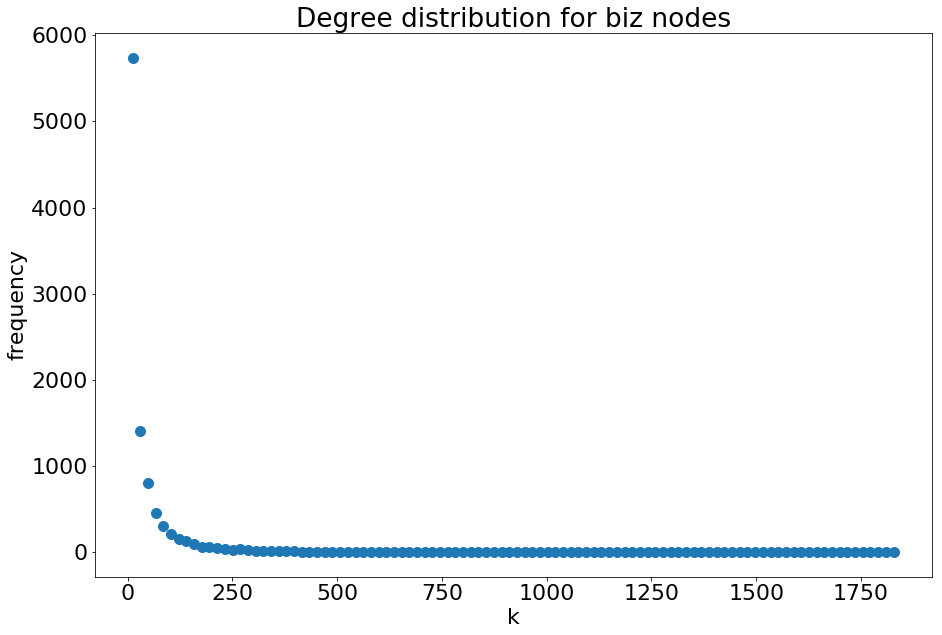

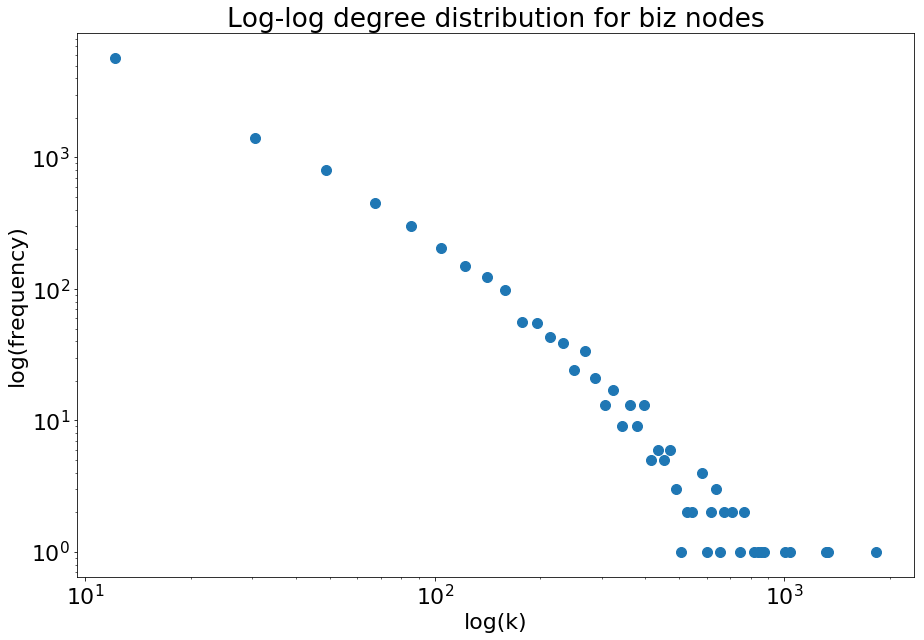

In [70]:
degree_plot(review_network, review_biz_nodes, "biz nodes")

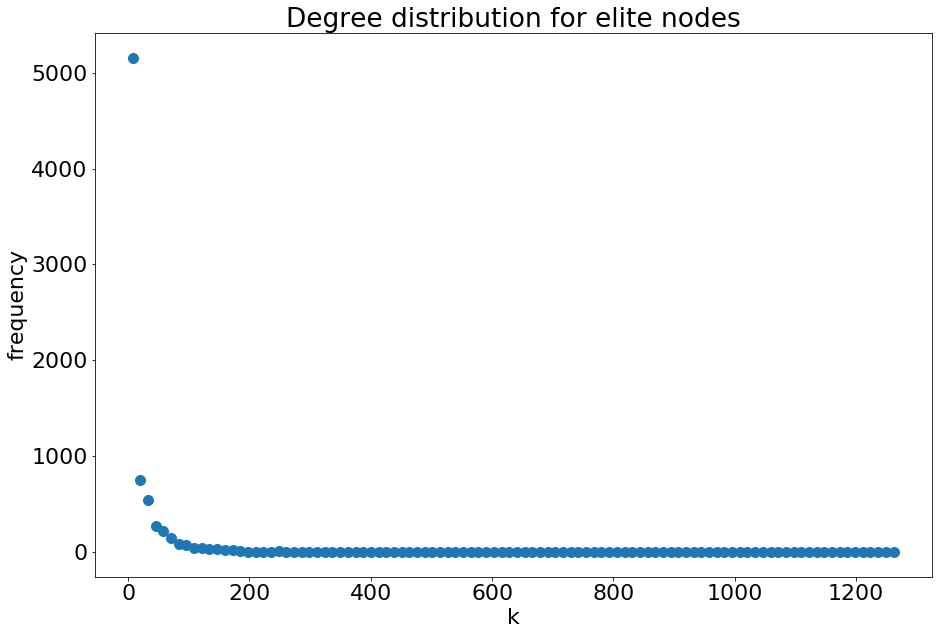

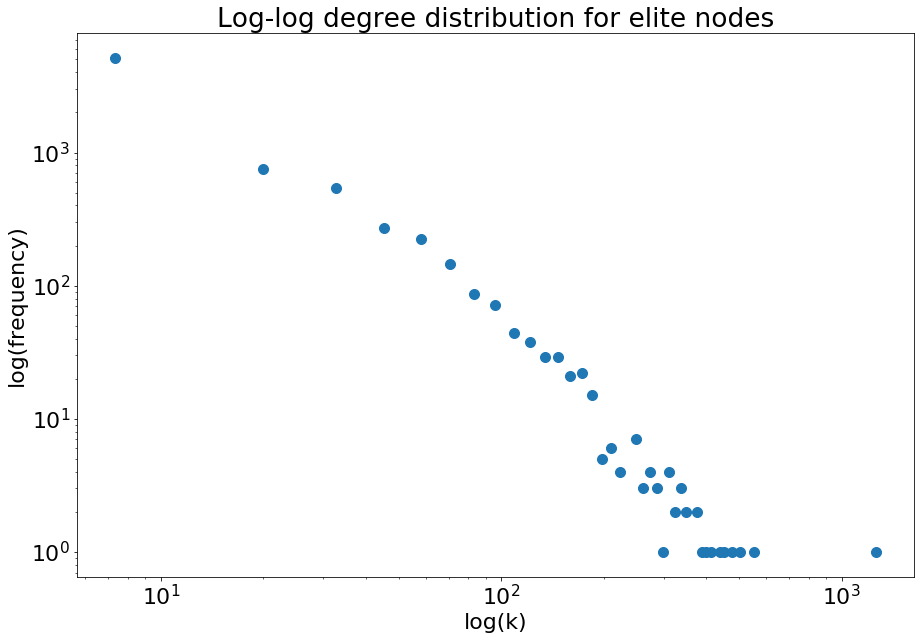

In [72]:
degree_plot(review_network, review_elite_nodes, "elite nodes")

In [76]:
print('Nodes:', len(review_network.nodes()))
print('Edges:', len(review_network.edges()))

Nodes: 94291
Edges: 379875


In [77]:
L = max(nx.connected_component_subgraphs(review_network), key=len)
print("Nodes in largest subcomponent:", len(L.nodes()))
print("Edges in largest subcomponent:", len(L.edges()))

Nodes in largest subcomponent: 94246
Edges in largest subcomponent: 379840


In [78]:
cluster_coeff_avg = nx.average_clustering(review_network)
print('Average clustering coeff. :', cluster_coeff_avg)

Average clustering coeff. : 2.843489088264669e-06


### Centrality: Elite vs Non-Elite

**Intro:** Eigenvector centrality for a user node indicates to which degree they have reviewed restaurants with many reviews.

In [107]:
centralities = [nx.degree, nx.eigenvector_centrality_numpy, nx.betweenness_centrality]

In [109]:
deg = nx.degree(review_network)
ev = nx.eigenvector_centrality_numpy(review_network)

In [110]:
ev_elite_user = [ev[n] for n in ev if n.Type == ELITE_USER]
ev_user = [ev[n] for n in ev if n.Type == USER]
elite_avg_ev = np.mean(ev_elite_user)
user_avg_ev = np.mean(ev_user)
all_user_ev = np.mean(ev_elite_user + ev_user)

In [114]:
deg_elite_user = [deg[n] for n in deg if n.Type == ELITE_USER]
deg_user = [deg[n] for n in deg if n.Type == USER]
elite_avg_deg = np.mean(deg_elite_user)
user_avg_deg = np.mean(deg_user)
all_user_deg = np.mean(deg_elite_user + deg_user)

In [112]:
print('Normal user mean EV centrality', user_avg_ev)
print('Elite user mean EV centrality', elite_avg_ev)
print('All users mean EV centrality', all_user_ev)
ratio = elite_avg_ev / user_avg_ev
print('Ratio (Elite : Normal): %.2f' % ratio)

Normal user mean EV centrality 0.000515172169059237
Elite user mean EV centrality 0.003457437062851881
All users mean EV centrality 0.0007759271614785319
Ratio (Elite : Normal): 6.71


In [115]:
print('Normal user mean Deg centrality', user_avg_deg)
print('Elite user mean Deg centrality', elite_avg_deg)
print('All users mean Deg centrality', all_user_deg)
ratio = elite_avg_deg / user_avg_deg
print('Ratio Deg (Elite : Normal): %.2f' % ratio)

Normal user mean Deg centrality 3.0597274271561394
Elite user mean Deg centrality 19.19215895452727
All users mean Deg centrality 4.489446440389524
Ratio Deg (Elite : Normal): 6.27


**Conclusion:** Elite users on average review 6.3 times as many restaurants, and review the most reviewed restaurants 6.7 times as frequently.